Используя базу "Аудиожанры", примените подход к музыке как к тексту и напишите сверточный классификатор (на базе слоя Conv1D) для подготовленных данных. Для этого:

1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом. Другими словами: берем аудио-файл длительность, например, 30 сек. Берем отрезок фиксированной длины (например, 5с) и получаем набор признаков для этого отрезка. Смещаемся на шаг (например, 1с) и берем следующий отрезок. Таким образом готовим обучающую вборку.
2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
4. Используйте за основу материал с урока, но при желании разработайте свои инструменты.

### Импортируем необходимые библиотеки и копируем необходимые данные:

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import tqdm

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Загрузим датасет в Colab:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=True)

'genres.zip'

In [ ]:
# Загрузка обработанного датасета из облака
gdown.download('https://drive.google.com/uc?id=1YNPAG3awTGynR8DWBaxWvPGGCIsD1_Iq', None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YNPAG3awTGynR8DWBaxWvPGGCIsD1_Iq
To: /content/audio_data_mean.pickle
100%|██████████| 3.55M/3.55M [00:00<00:00, 253MB/s]


'audio_data_mean.pickle'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00017.au	blues.00034.au	blues.00051.au	blues.00068.au	blues.00085.au
blues.00001.au	blues.00018.au	blues.00035.au	blues.00052.au	blues.00069.au	blues.00086.au
blues.00002.au	blues.00019.au	blues.00036.au	blues.00053.au	blues.00070.au	blues.00087.au
blues.00003.au	blues.00020.au	blues.00037.au	blues.00054.au	blues.00071.au	blues.00088.au
blues.00004.au	blues.00021.au	blues.00038.au	blues.00055.au	blues.00072.au	blues.00089.au
blues.00005.au	blues.00022.au	blues.00039.au	blues.00056.au	blues.00073.au	blues.00090.au
blues.00006.au	blues.00023.au	blues.00040.au	blues.00057.au	blues.00074.au	blues.00091.au
blues.00007.au	blues.00024.au	blues.00041.au	blues.00058.au	blues.00075.au	blues.00092.au
blues.00008.au	blues.00025.au	blues.00042.au	blues.00059.au	blues.00076.au	blues.00093.au
blues.00009.au	blues.00026.au	blues.00043.au	blues.00060.au	blues.00077.au	blues.00094.au
blues.00010.au	blues.00027.a

### Подготовка данных

In [ ]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 25                         # Анализируемая длительность аудиосигнала
WINDOW_SIZE_SEC = 5                       # Окно фиксированной длины
STEP_SIZE_SEC = 1                         # Смещение на шаг
SAMPLE_RATE = 22050                       # Пример частоты дискретизации, можно изменить на реальную частоту

N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [ ]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Сборка параметров в общий список:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

def stack_features_y(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat:
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)\

    return feature_set, y_label

In [ ]:
def get_features_from_windows(class_index,
                              song_name,
                              duration_sec,
                              window_duration,
                              step_duration):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Подсчет количества окон
    total_windows = (len(y) - window_duration * sr) // (step_duration * sr) + 1

    # Инициализация пустых списков для признаков и меток
    features_list = []
    labels_list = []

    for i in range(total_windows):
        # Определение начала и конца окна
        start_sample = int(i * step_duration * sr)
        end_sample = int(start_sample + window_duration * sr)

        # Извлечение оконного сегмента аудио
        windowed_audio = y[start_sample:end_sample]

        # Извлечение признаков из оконного сегмента
        features = get_features(windowed_audio, sr)
        feature_set = stack_features(features)

        # Перевод номера класса в one hot encoding
        y_label = to_categorical(class_index, CLASS_COUNT)
        y_label_set = stack_features_y(y_label)

        # Добавление в списки
        features_list.append(feature_set)
        labels_list.append(y_label_set)

    return features_list, labels_list

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,     # индекс класса аудиофайла
                 file_index,      # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec,    # длительность аудио в секундах
                 window_duration, # длительность окна
                 step_duration    # шаг перемещения окна
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set_list, y_label_list = get_features_from_windows(class_index,
                                                     song_name,
                                                     duration_sec,
                                                     window_duration,
                                                     step_duration)

    # Добавление данных в наборы
    for i in range(len(feature_set_list)):
        feature_set = feature_set_list[i]
        y_label = y_label_list[i]
        x_list.extend(feature_set)  # Используйте extend для добавления всех элементов вместо цикла
        y_list.extend(y_label)  # То же самое для y_list

    # Возврат имени файла и numpy-массивов признаков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

* Рассчитываем размер окна и шага в сэмплах, а не в секундах.
* Затем, при обработке каждого аудиофайла, вы разбиваете данные на последовательности с фиксированным размером окна и шагом.
* Последовательности добавляются к общему массиву x_data, а метки к y_data.
* Теперь функция extract_data будет возвращать последовательности векторов признаков, где каждая последовательность представляет собой отрезок аудиофайла фиксированного размера с заданным шагом.

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,                # начальный индекс аудиофайла
                 file_index_end,                  # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC,       # длительность аудио в секундах
                 window_duration=WINDOW_SIZE_SEC, # длительность окна
                 step_duration=STEP_SIZE_SEC      # шаг перемещения окна
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in tqdm(range(len(CLASS_LIST))):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in tqdm(range(file_index_start, file_index_end)):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index,
                                                       file_index,
                                                       duration_sec,
                                                       window_duration,
                                                       step_duration)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов

x_train_data, y_train_data = extract_data(0, 90)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Жанр blues готов -> 732 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр classical готов -> 725 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр country готов -> 708 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр disco готов -> 709 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр hiphop готов -> 703 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр jazz готов -> 712 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр metal готов -> 722 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр pop готов -> 721 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр reggae готов -> 716 c


  0%|          | 0/90 [00:00<?, ?it/s]

Жанр rock готов -> 725 c


### Сохранение

In [ ]:
# Создать кортеж (или список) с данными для сохранения

# Указать путь к файлу для сохранения данных
save_path = '/content/audio_data_mean.pickle'

In [ ]:
# Сохранить данные в файл
#data_to_save = (x_train_data, y_train_data)

#with open(save_path, 'wb') as f:
#    pickle.dump(data_to_save, f)

In [ ]:
with open(save_path, 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

### Далее

In [ ]:
print(f'Обучающая выборка x_train: {x_train_data.shape}')
print(f'Обучающая выборка y_train: {y_train_data.shape}')

Обучающая выборка x_train: (18900, 37)
Обучающая выборка y_train: (18900, 10)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением

x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения

x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

### Функция вывода графиков точности и ошибки по эпохам обучения

In [ ]:
# Вывод графиков точности и ошибки распознавания на обучающей и проверочной выборках

def show_history(history  # объект-результат метода обучения .fit()
                 ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

### Функции визуализации распознавания отдельных звуковых файлов

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,           # обученная модель классификатора
                  x_scaler,        # настроенный нормировщих входных данных
                  class_index,     # верный индекс класса аудиофайла
                  file_index,      # индекс (порядковый номер) аудиофайла в папке
                  window_duration, # длительность окна
                  step_duration    # шаг перемещения окна
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC, window_duration, step_duration)

    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса

def classify_test_files(model,           # обученная модель классификатора
                        x_scaler,        # настроенный нормировщих входных данных
                        from_index,      # индекс аудиофайла, с которого начинать визуализацию
                        n_files,         # количество файлов для визуализации
                        window_duration, # Окно фиксированной длины
                        step_duration):  # Смещение на шаг
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []

    # Классификация каждого файла и аккумуляция результатов классификации
    for class_index in tqdm(range(CLASS_COUNT)):
        for file_index in tqdm(range(from_index, from_index + n_files)):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index, window_duration, step_duration)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

### Обучение

In [ ]:
# Обучающая выборка x_train: (810, 37)
# Обучающая выборка y_train: (810, 10)
# Проверочная (валидационная) выборка x_val: (90, 37)
# Проверочная (валидационная) выборка y_val: (90, 10)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

print(f'Обучающая выборка x_train: {x_train.shape}')
print(f'Обучающая выборка y_train: {y_train.shape}')

print(f'Проверочная (валидационная) выборка x_val: {x_val.shape}')
print(f'Проверочная (валидационная) выборка y_val: {y_val.shape}')

Обучающая выборка x_train: (17010, 37, 1)
Обучающая выборка y_train: (17010, 10)
Проверочная (валидационная) выборка x_val: (1890, 37, 1)
Проверочная (валидационная) выборка y_val: (1890, 10)


In [ ]:
# Создание и компиляция модели
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (x_train.shape[1], 1)

model = create_model(input_shape, CLASS_COUNT)

In [ ]:
# Вывод информации о модели
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 35, 64)            256       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 17, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 15, 32)            6176      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 224)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
# Ваше решение
# Обучение сети
epochs = 50
batch_size = 32
history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    verbose = 1)

Epoch 1/50
532/532 [==============================] - 5s 5ms/step - loss: 2.0272 - accuracy: 0.2667 - val_loss: 1.6989 - val_accuracy: 0.4159
Epoch 2/50
532/532 [==============================] - 3s 5ms/step - loss: 1.6834 - accuracy: 0.3956 - val_loss: 1.5036 - val_accuracy: 0.4868
Epoch 3/50
532/532 [==============================] - 2s 4ms/step - loss: 1.5420 - accuracy: 0.4583 - val_loss: 1.3743 - val_accuracy: 0.5460
Epoch 4/50
532/532 [==============================] - 2s 4ms/step - loss: 1.4416 - accuracy: 0.4968 - val_loss: 1.2733 - val_accuracy: 0.5667
Epoch 5/50
532/532 [==============================] - 3s 6ms/step - loss: 1.3498 - accuracy: 0.5317 - val_loss: 1.1930 - val_accuracy: 0.5905
Epoch 6/50
532/532 [==============================] - 3s 6ms/step - loss: 1.2742 - accuracy: 0.5526 - val_loss: 1.1235 - val_accuracy: 0.6185
Epoch 7/50
532/532 [==============================] - 3s 6ms/step - loss: 1.2161 - accuracy: 0.5737 - val_loss: 1.0679 - val_accuracy: 0.6397
Epoch 

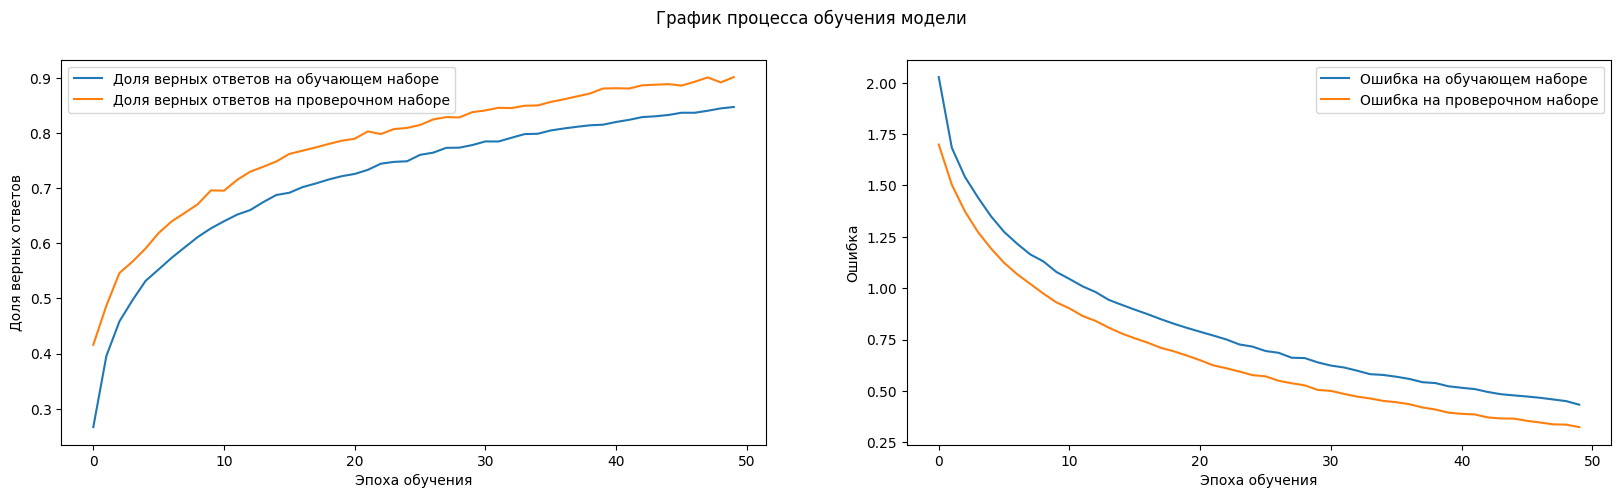

In [ ]:
# Вывод графиков
show_history(history)

Файл: ./genres/blues/blues.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: country - НЕВЕРНО.


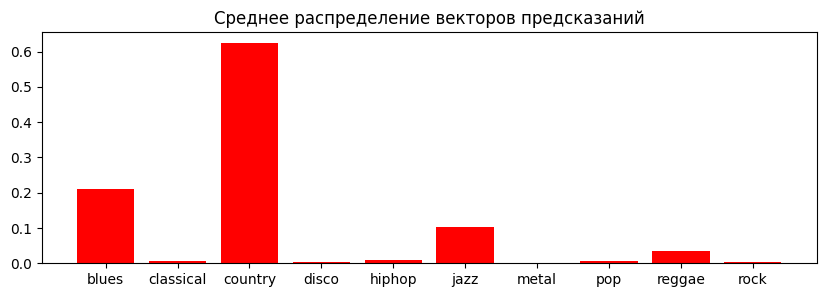

---------------------------------------------------------------
Файл: ./genres/blues/blues.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: blues - ВЕРНО :-)


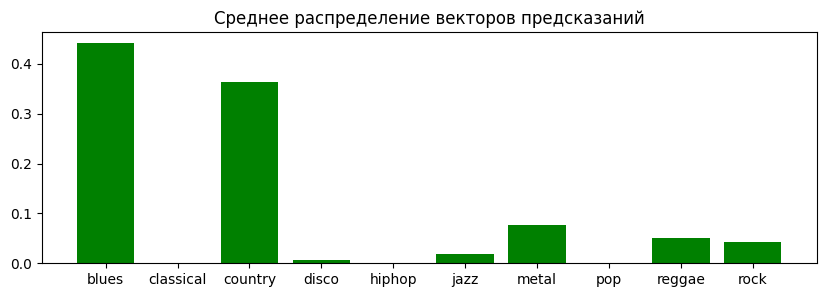

---------------------------------------------------------------
Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: blues - ВЕРНО :-)


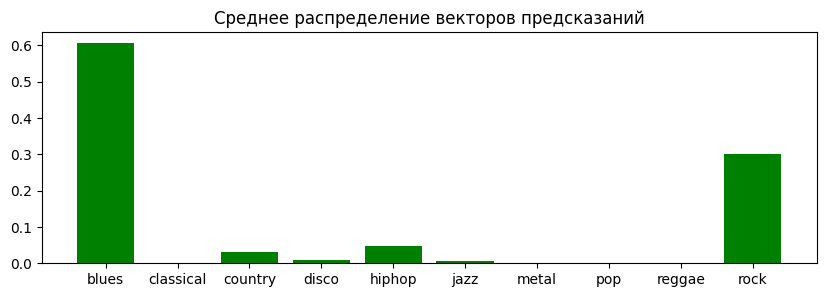

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: country - НЕВЕРНО.


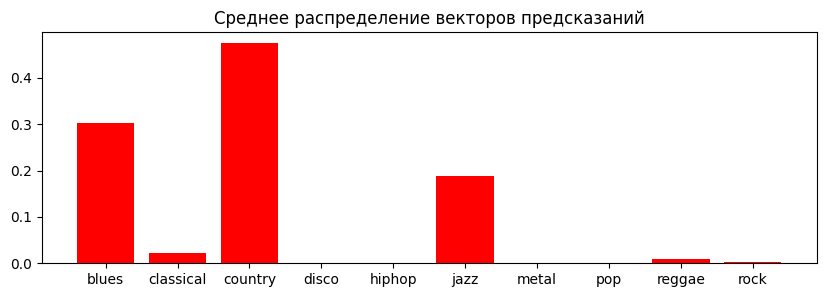

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: rock - НЕВЕРНО.


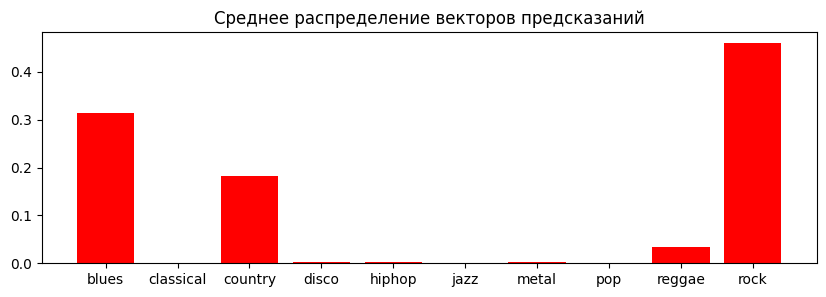

---------------------------------------------------------------
Файл: ./genres/classical/classical.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 29ms/step
Классификация сети: classical - ВЕРНО :-)


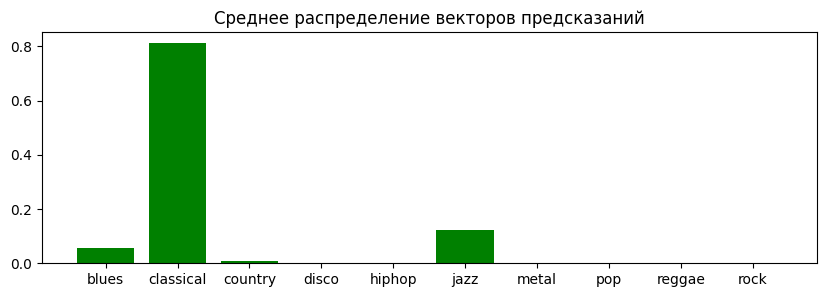

---------------------------------------------------------------
Файл: ./genres/classical/classical.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: classical - ВЕРНО :-)


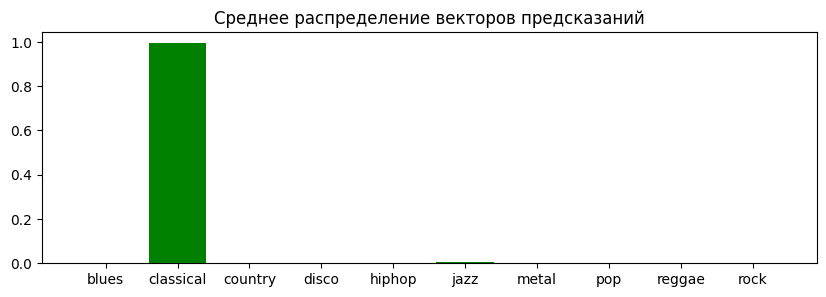

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: classical - ВЕРНО :-)


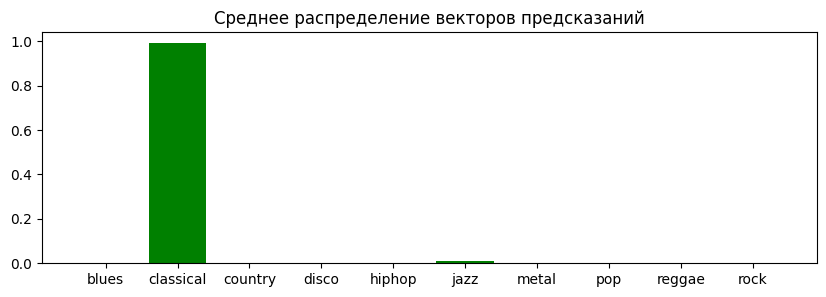

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: classical - ВЕРНО :-)


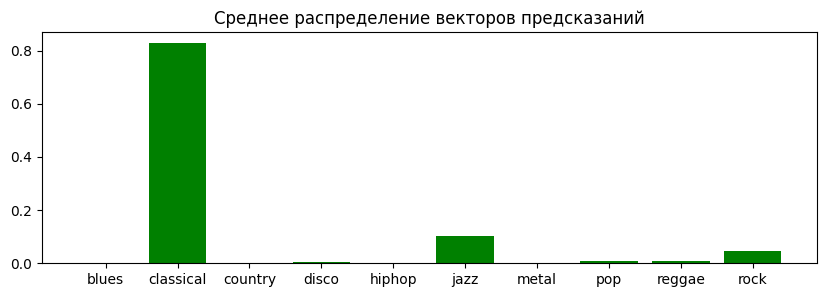

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 17ms/step
Классификация сети: classical - ВЕРНО :-)


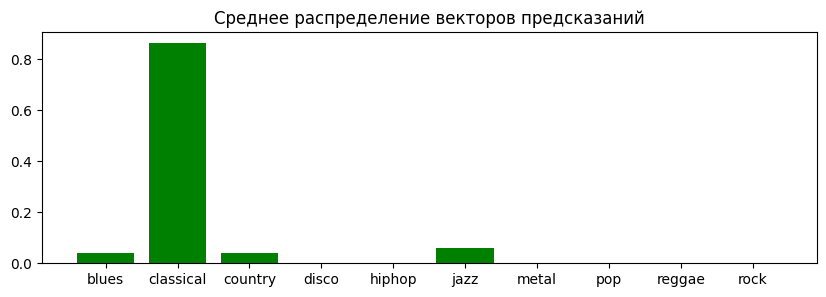

---------------------------------------------------------------
Файл: ./genres/country/country.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: country - ВЕРНО :-)


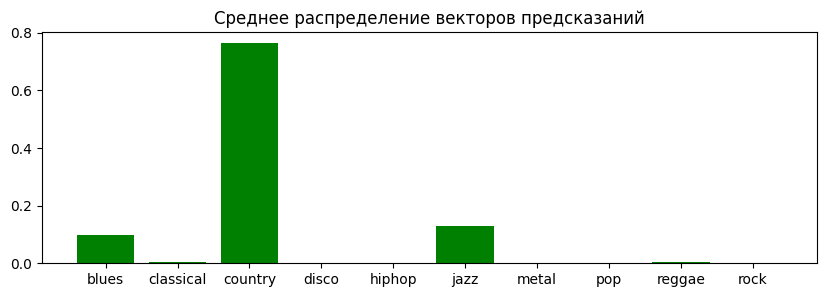

---------------------------------------------------------------
Файл: ./genres/country/country.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: blues - НЕВЕРНО.


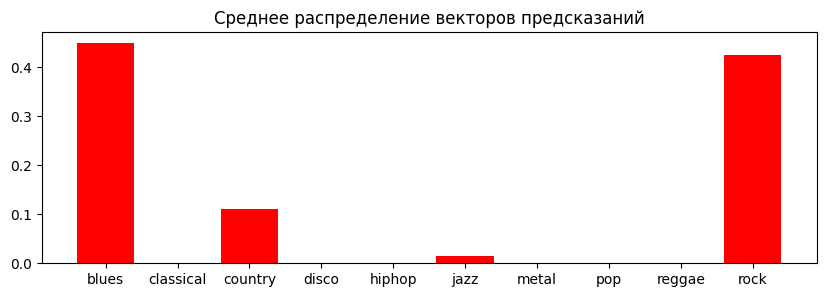

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: blues - НЕВЕРНО.


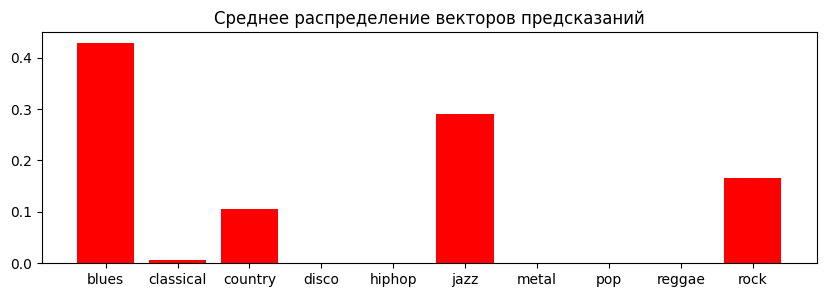

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: rock - НЕВЕРНО.


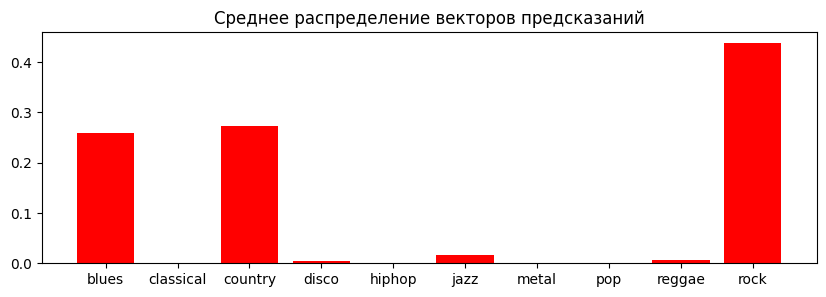

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: blues - НЕВЕРНО.


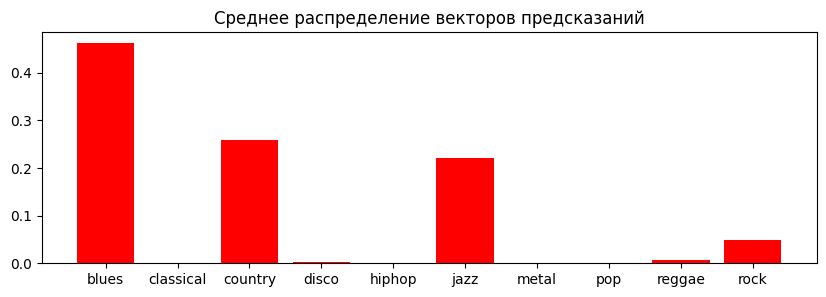

---------------------------------------------------------------
Файл: ./genres/disco/disco.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 29ms/step
Классификация сети: disco - ВЕРНО :-)


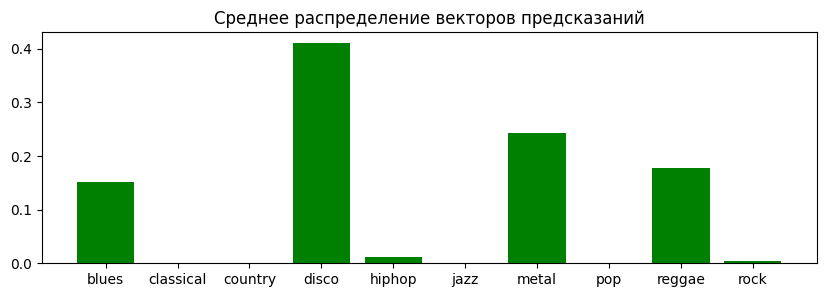

---------------------------------------------------------------
Файл: ./genres/disco/disco.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 26ms/step
Классификация сети: disco - ВЕРНО :-)


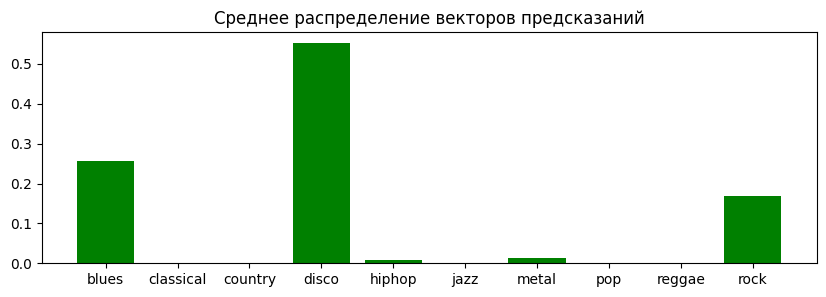

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: metal - НЕВЕРНО.


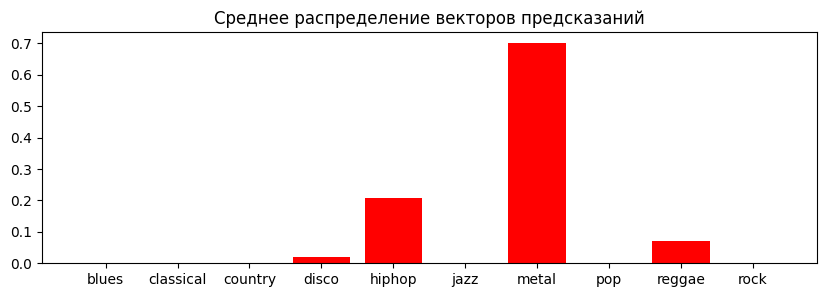

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: metal - НЕВЕРНО.


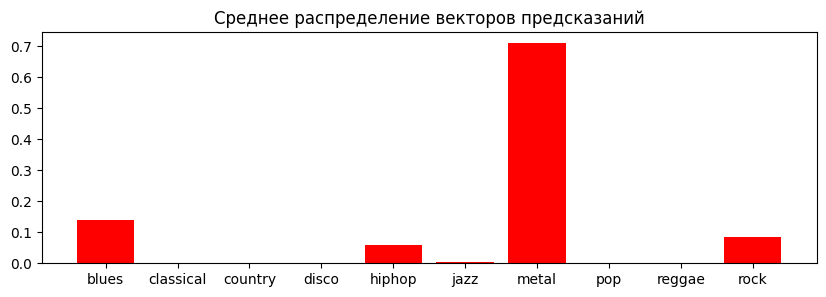

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: reggae - НЕВЕРНО.


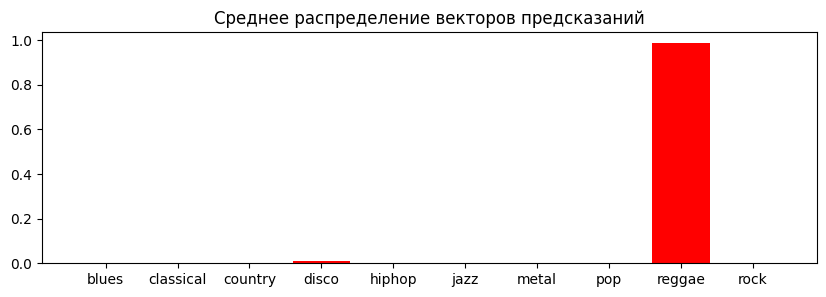

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: metal - НЕВЕРНО.


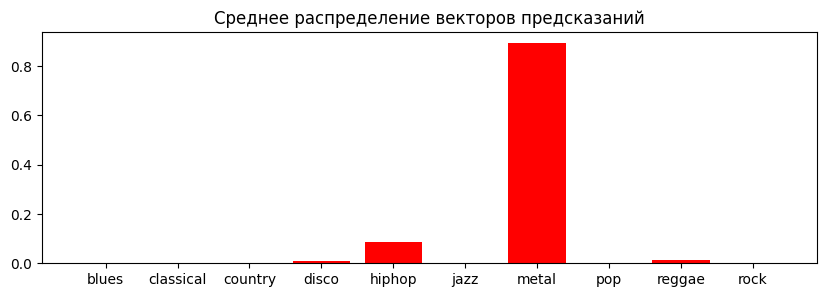

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: reggae - НЕВЕРНО.


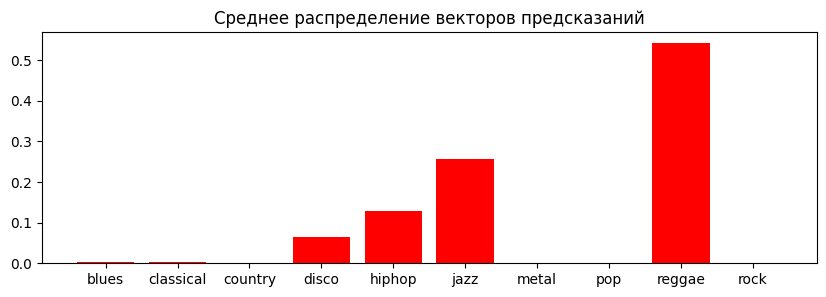

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 17ms/step
Классификация сети: metal - НЕВЕРНО.


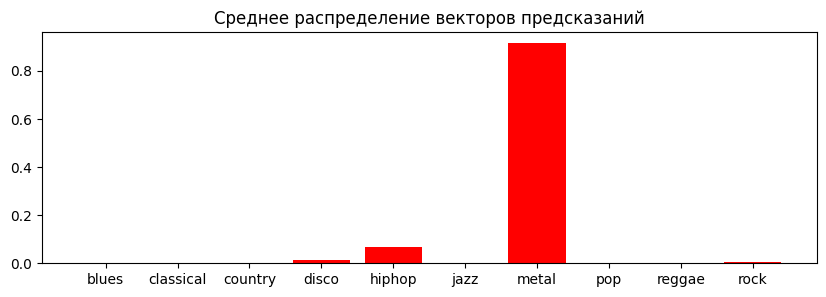

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: hiphop - ВЕРНО :-)


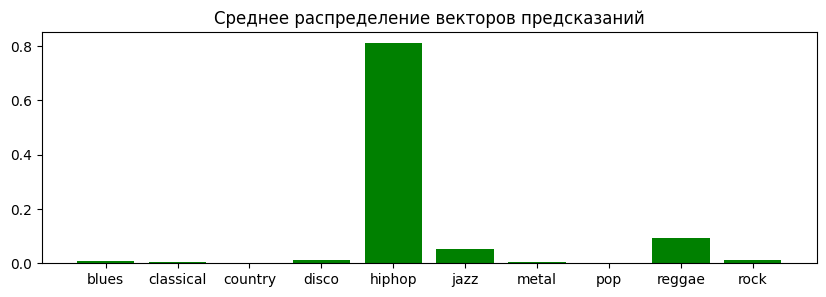

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 17ms/step
Классификация сети: hiphop - ВЕРНО :-)


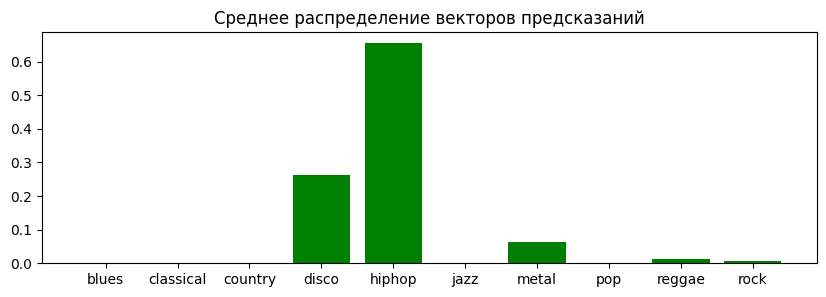

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: jazz - ВЕРНО :-)


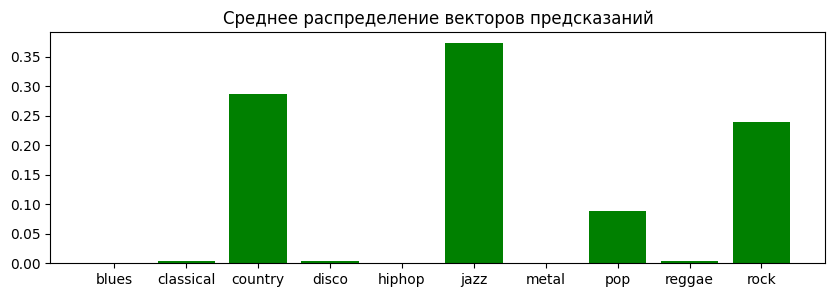

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: jazz - ВЕРНО :-)


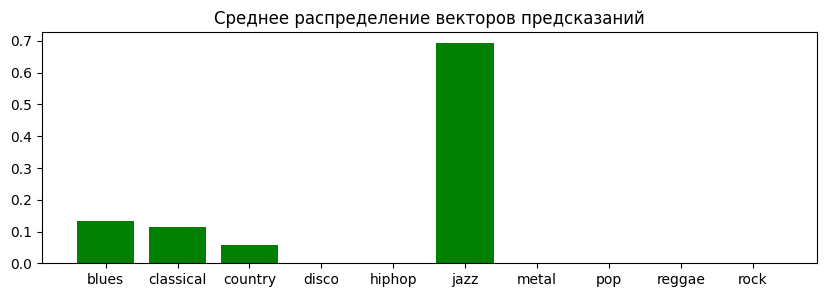

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: jazz - ВЕРНО :-)


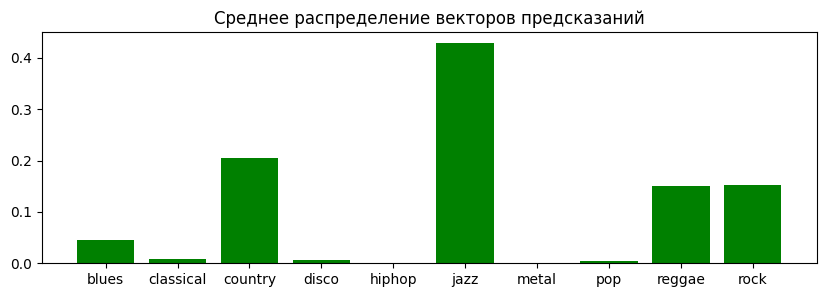

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: jazz - ВЕРНО :-)


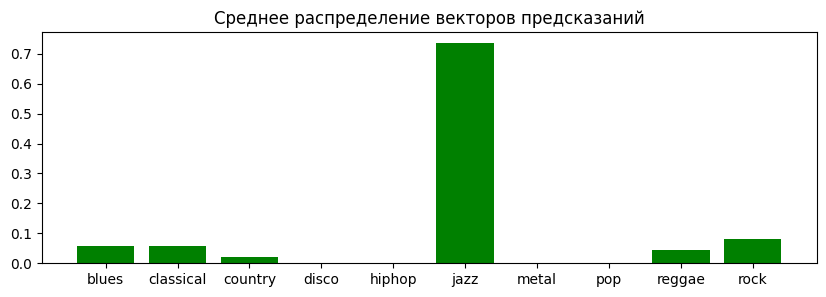

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: jazz - ВЕРНО :-)


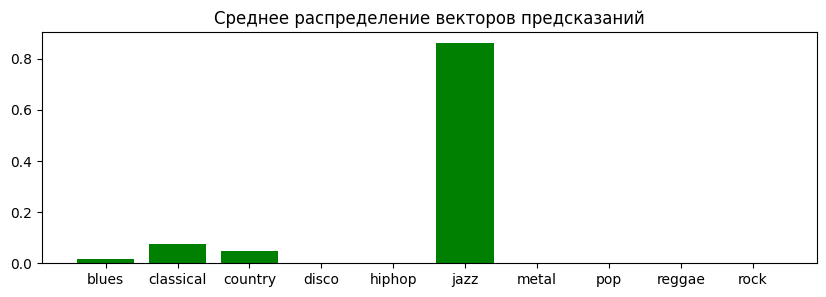

---------------------------------------------------------------
Файл: ./genres/metal/metal.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: metal - ВЕРНО :-)


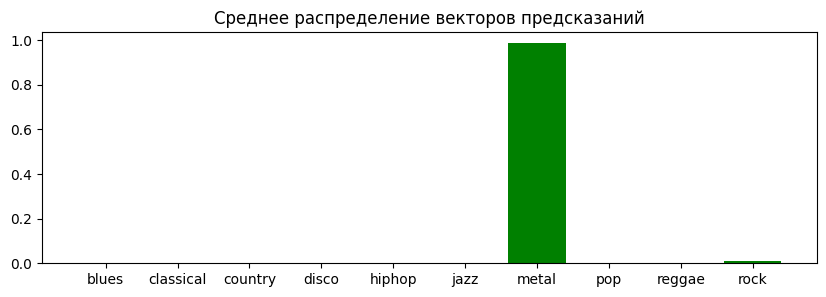

---------------------------------------------------------------
Файл: ./genres/metal/metal.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: metal - ВЕРНО :-)


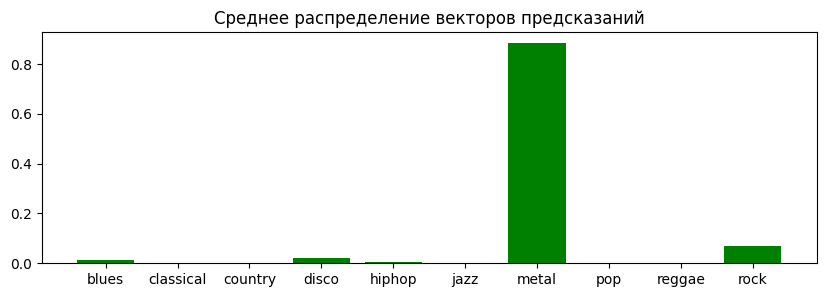

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: metal - ВЕРНО :-)


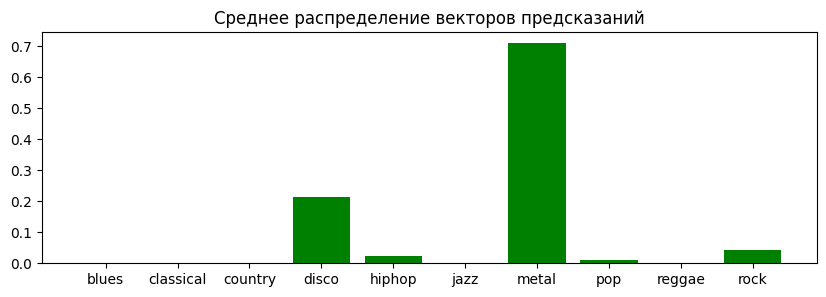

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: metal - ВЕРНО :-)


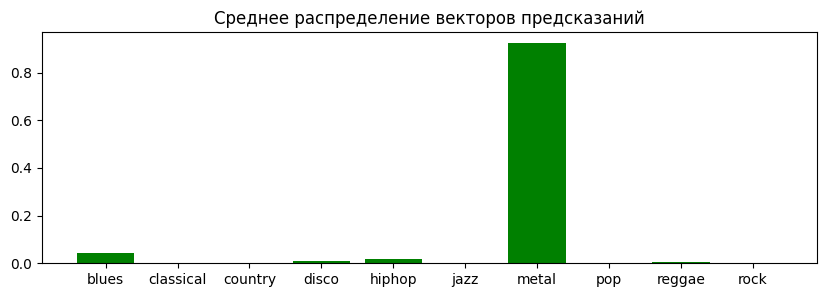

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: metal - ВЕРНО :-)


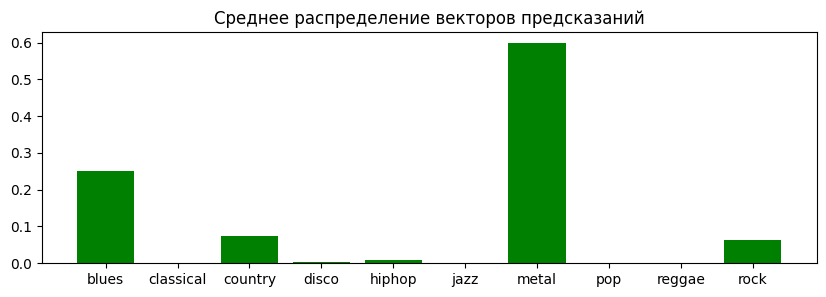

---------------------------------------------------------------
Файл: ./genres/pop/pop.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: pop - ВЕРНО :-)


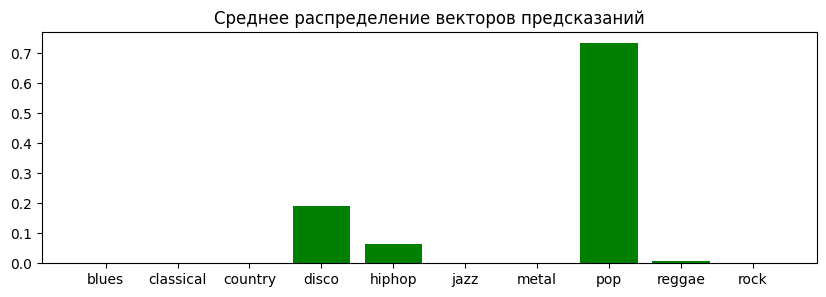

---------------------------------------------------------------
Файл: ./genres/pop/pop.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 49ms/step
Классификация сети: pop - ВЕРНО :-)


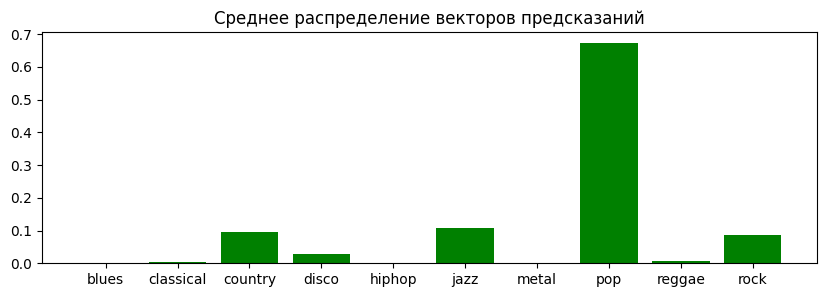

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: pop - ВЕРНО :-)


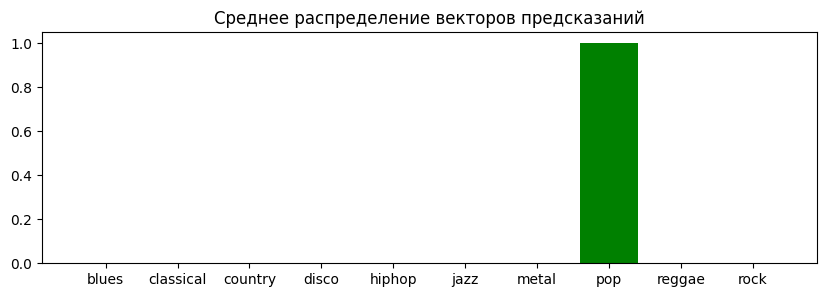

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: pop - ВЕРНО :-)


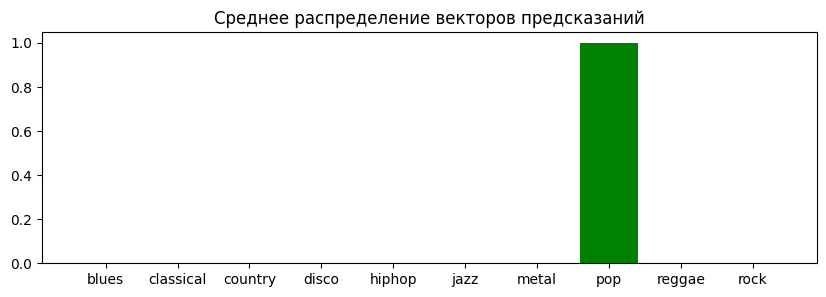

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: pop - ВЕРНО :-)


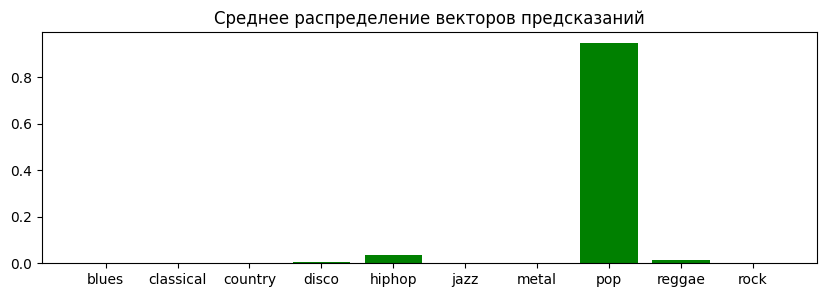

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: country - НЕВЕРНО.


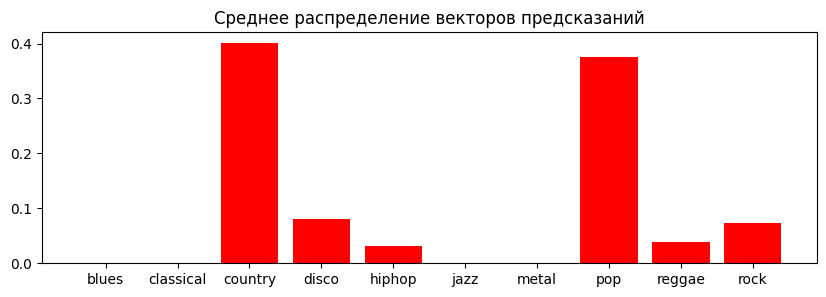

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: country - НЕВЕРНО.


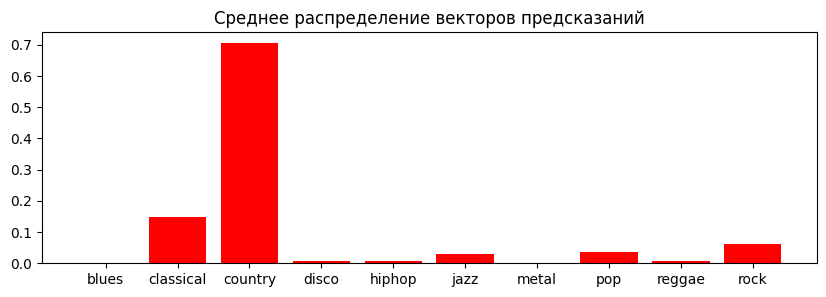

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 29ms/step
Классификация сети: hiphop - НЕВЕРНО.


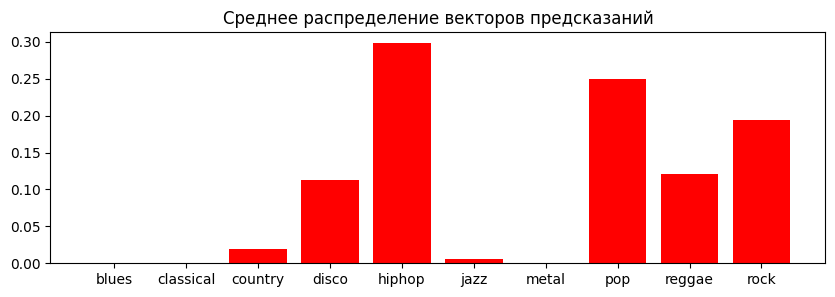

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: reggae - ВЕРНО :-)


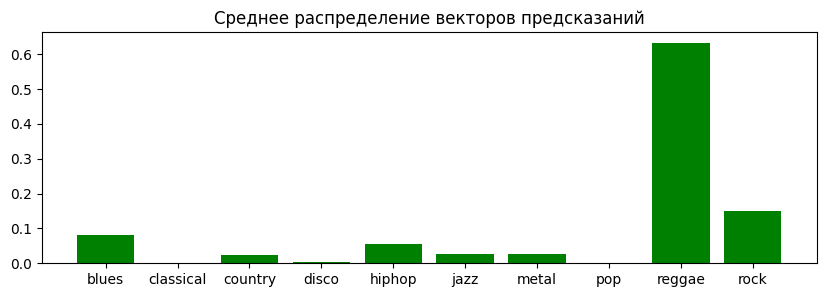

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: country - НЕВЕРНО.


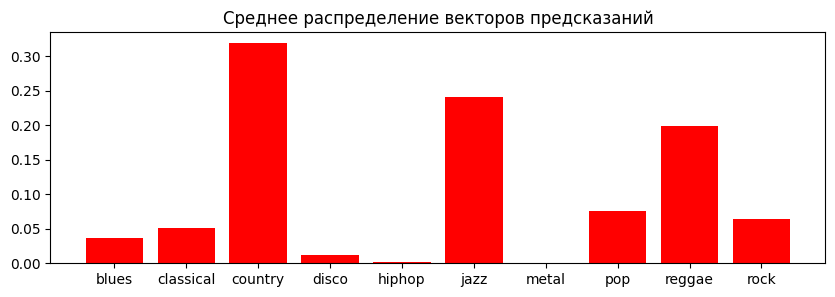

---------------------------------------------------------------
Файл: ./genres/rock/rock.00093.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: rock - ВЕРНО :-)


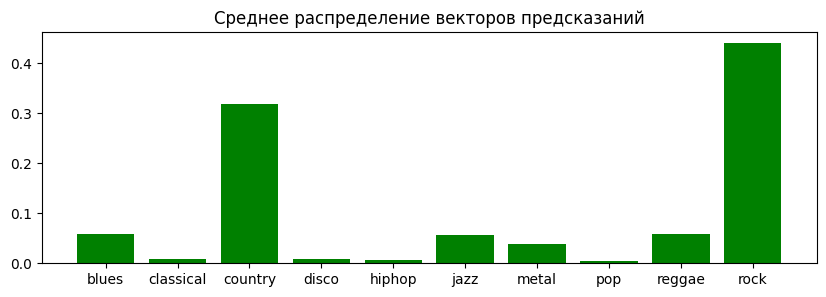

---------------------------------------------------------------
Файл: ./genres/rock/rock.00094.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 19ms/step
Классификация сети: metal - НЕВЕРНО.


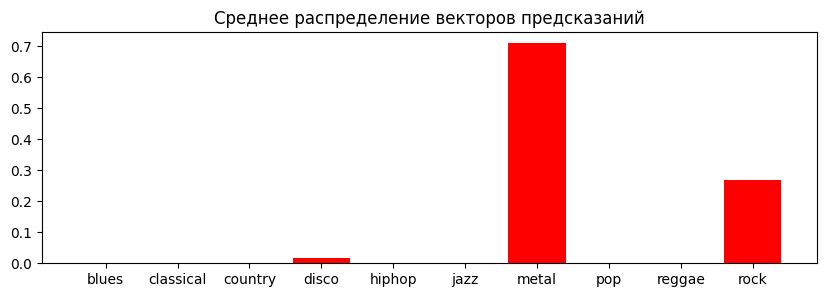

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: country - НЕВЕРНО.


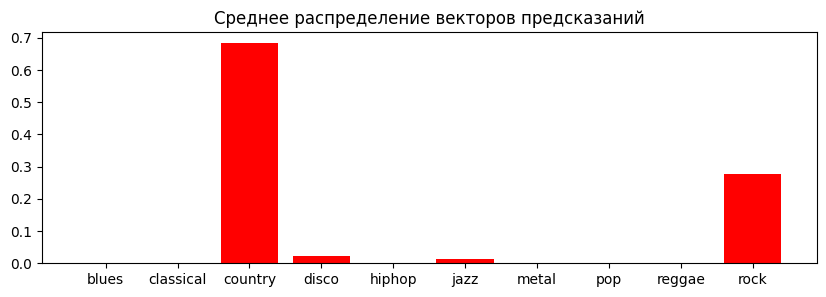

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 18ms/step
Классификация сети: rock - ВЕРНО :-)


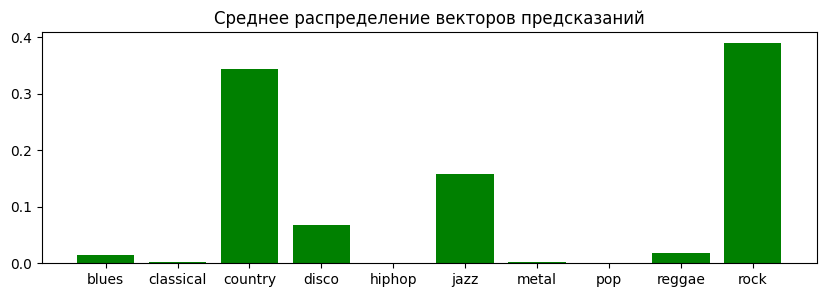

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (21, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: country - НЕВЕРНО.


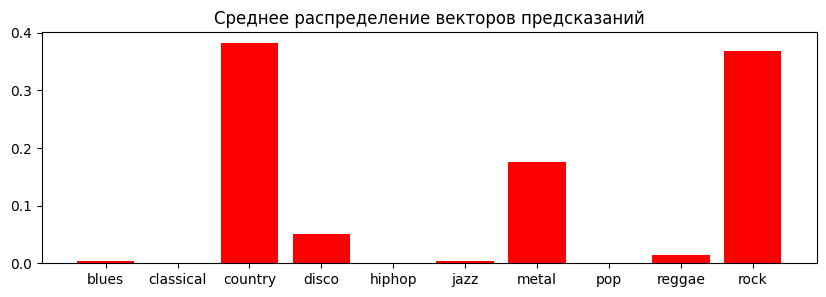

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 30, доля верных: 60.0% ===


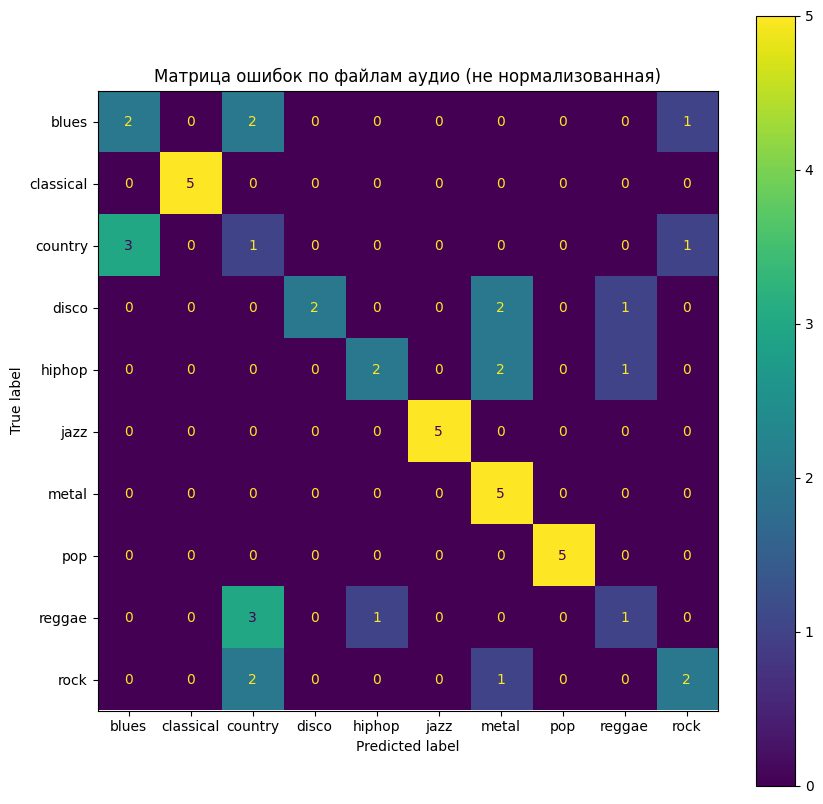

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса
from_index = 93                   # Индекс файла - с какого начинаем предсказание
n_files = 5                       # Количество файлов для предсказания
window_duration = WINDOW_SIZE_SEC # Окно фиксированной длины
step_duration = STEP_SIZE_SEC     # Смещение на шаг

classify_test_files(model,           # обученная модель классификатора
                    x_scaler,        # настроенный нормировщих входных данных
                    from_index,      # индекс аудиофайла, с которого начинать визуализацию
                    n_files,         # количество файлов для визуализации
                    window_duration, # Окно фиксированной длины
                    step_duration)   # Смещение на шаг

60/60 [==============================] - 0s 3ms/step - loss: 0.3237 - accuracy: 0.9011
Ошибка: 0.32374367117881775, точность: 0.9010581970214844
60/60 [==============================] - 0s 2ms/step


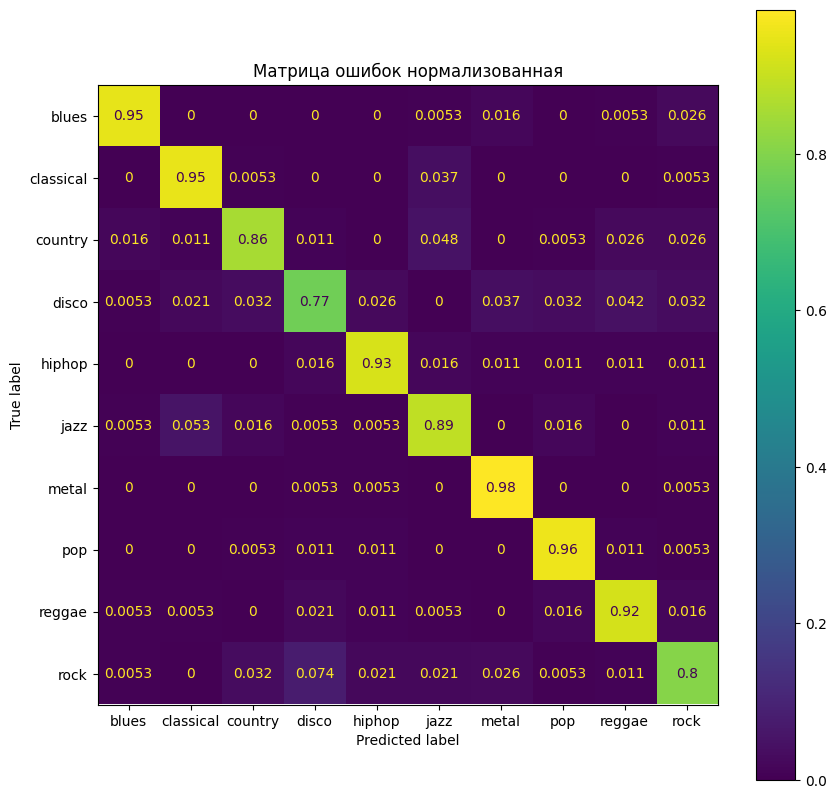

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель классификатора
               x,      # входные данные для предсказаний модели
               y_true  # выходные данные (верные ответы)
               ):

    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

eval_model(model, x_val, y_val)

Все целевые функции достигнуты. Есть потенциал улучшения точности при увеличении количества эпох, что видно на графиках обучения.